In [220]:
import logging
import threading
import itertools
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as seabornInstance
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import base
from iotfunctions import bif
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType
from iotfunctions.db import Database
from iotfunctions.enginelog import EngineLogging
from iotfunctions import estimator
from iotfunctions.ui import (UISingle, UIMultiItem, UIFunctionOutSingle,
                 UISingleItem, UIFunctionOutMulti, UIMulti, UIExpression,
                 UIText, UIStatusFlag, UIParameters)
import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import scipy as sp
import scipy.fftpack
import skimage as ski  
from skimage import util as skiutil # for nifty windowing
import pyod as pyod
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from pyod.models.knn import KNN
from pyod.models.iforest import IForest
%matplotlib inline

2019-10-02T20:03:26.580 DEBUG matplotlib.pyplot.switch_backend Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [221]:
credentials = {
  "tenantId": "AnalyticsServiceDev",
  "as_api_host": "https://api-dev.connectedproducts.internetofthings.ibmcloud.com",
  "as_api_key": "a-69xgm4-8bdgtvnsv4",
  "as_api_token": "9X_tMKdupOiJ!mzaPV",
  "config" : {
      "objectStorageEndpoint" : "https://s3-api.us-geo.objectstorage.softlayer.net",
      "bos_runtime_bucket" : "analytics-runtime-analyticsservicedev-799d2008b460",
      "bos_logs_bucket" : "analytics-logs-analyticsservicedev-32703c52ec8b"
  },
  "objectStorage": {
      "username" : "58ddd86b5de8468b819d385046f17033",
      "password" : "ee0d6c5521ce9ff100f91b0e37d4eb8cc1a038b5a6d05b38",
      "region" : "us",
      "endpoint" : "https://s3-api.us-geo.objectstorage.softlayer.net"
  },
  "db2": {
    "username": "bluadmin",
    "password": "ZmM5MmE5NmZkZGZl",
    "databaseName": "BLUDB",
    "port": 50000,
    "httpsUrl": "https://dashdb-enterprise-yp-dal13-74.services.dal.bluemix.net:50000",
    "host": "dashdb-enterprise-yp-dal13-74.services.dal.bluemix.net"
  }
}
EngineLogging.configure_console_logging(logging.DEBUG)

2019-10-02T20:03:27.217 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10


In [222]:
db_schema = None
db = Database(credentials=credentials)
print (db)

2019-10-02T20:03:28.524 DEBUG iotfunctions.db.__init__ Unable to locate message_hub credentials. Database object created, but it will not be able interact with message hub.
2019-10-02T20:03:28.525 INFO iotfunctions.db.__init__ Connection string for SqlAlchemy => db2): db2+ibm_db://bluadmin:ZmM5MmE5NmZkZGZl@dashdb-enterprise-yp-dal13-74.services.dal.bluemix.net:50000/BLUDB;
2019-10-02T20:03:28.526 DEBUG iotfunctions.db.__init__ created a CosClient object
2019-10-02T20:03:31.414 DEBUG iotfunctions.db.__init__ Db connection established
2019-10-02T20:03:31.415 DEBUG urllib3.connectionpool._new_conn Starting new HTTPS connection (1): api-dev.connectedproducts.internetofthings.ibmcloud.com


/home/markus/.local/lib/python3.7/site-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


2019-10-02T20:03:35.972 DEBUG urllib3.connectionpool._make_request https://api-dev.connectedproducts.internetofthings.ibmcloud.com:443 "GET /api/meta/v1/AnalyticsServiceDev/entityType HTTP/1.1" 200 None
2019-10-02T20:03:36.539 DEBUG iotfunctions.db.http_request http request successful. status 200


In [223]:
# Get stuff in
df_input = pd.read_csv('./Anomaly_Sample_data.csv',
                  parse_dates=['EVT_TIMESTAMP','UPDATED_UTC'])

# and sort it by timestamp
df_input = df_input.sort_values(by='EVT_TIMESTAMP')

df_input.head(3)


,DEVICEID,EVT_TIMESTAMP,DEVICETYPE,LOGICALINTERFACE_ID,EVENTTYPE,FORMAT,UPDATED_UTC,PRESSURE,TEMPERATURE,TURBINE_ID
316,B102,2019-09-26 18:08:11.262975,EnergySystemModel02,NaN,NaN,NaN,2019-09-26 18:08:11.262999,97.384763,77.907810,NaN
315,A101,2019-09-26 18:08:11.262975,EnergySystemModel02,NaN,NaN,NaN,2019-09-26 18:08:11.262999,97.384763,79.333185,NaN
317,A101,2019-09-26 18:18:06.486895,EnergySystemModel02,NaN,NaN,NaN,2019-09-26 18:18:06.486921,94.630009,77.907810,NaN


In [224]:
# start with a single sensor
df_temp = df_input[(df_input.DEVICEID == 'A101')][['EVT_TIMESTAMP','PRESSURE','TEMPERATURE']]

# turn timestamp into the index
df_temp = df_temp.set_index('EVT_TIMESTAMP')

# fill out the time gaps by backward filling - 2nd order splines are overkill I guess
upsampled = df_temp.resample('5min').bfill()
df_temp = upsampled.interpolate(method='spline', order=2)

# we have 963 data points
print (len(df_temp))

963


Text(0, 0.5, 'Temperature')

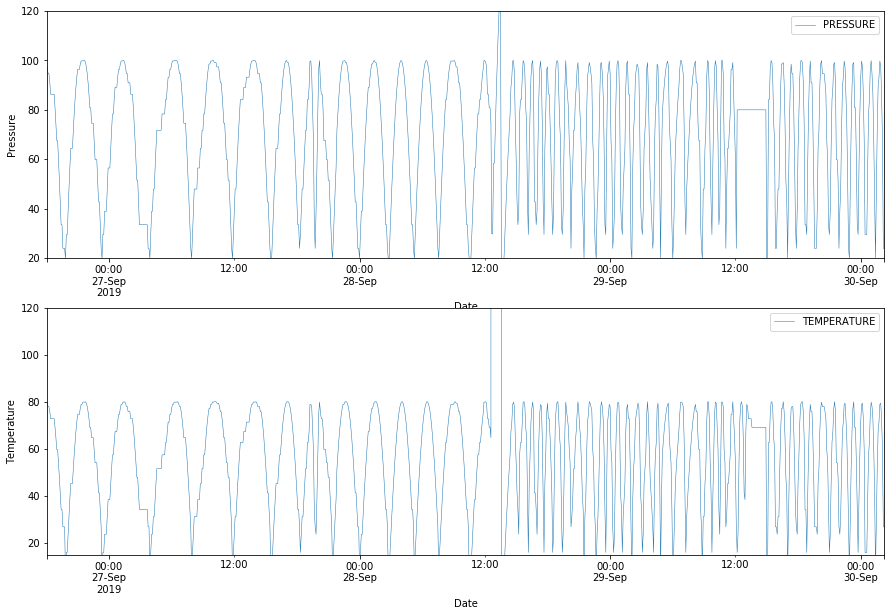

In [225]:
#df_temp = df_input[(df_input.DEVICEID == 'A101')]
#tmin = df_temp.head(1).EVT_TIMESTAMP.astype(np.int64)
#tmax = df_temp.tail(1).EVT_TIMESTAMP.astype(np.int64)
#tdiff = np.subtract(tmax, tmin) // 300000000000  # from nanosec to 5 min steps


fig, ax = plt.subplots(2, 1, figsize=(15, 10))
#df_temp.plot(ax=ax[0], lw=.5, x='EVT_TIMESTAMP', y='PRESSURE')
df_temp.plot(ax=ax[0], lw=.5, y='PRESSURE')
ax[0].set_ylim(20, 120)
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Pressure')
#df_temp.plot(ax=ax[1], lw=.5, x='EVT_TIMESTAMP', y='TEMPERATURE')
df_temp.plot(ax=ax[1], lw=.5, y='TEMPERATURE')
ax[1].set_ylim(15, 120)
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Temperature')

In [226]:
# Fourier transform
temp_fft = sp.fftpack.fft2(df_temp[['PRESSURE','TEMPERATURE']])
# Spectral density (energy per frequency)
temp_psd = np.abs(temp_fft) ** 2
# return sample frequencies - roughly every 5 mins
frame_rate = 1 / 288  # Hz = fft_freq * frame_rate
fftfreq = sp.fftpack.fftfreq(len(temp_psd), frame_rate)
i = fftfreq > 0

Text(0, 0.5, 'PSD (dB)')

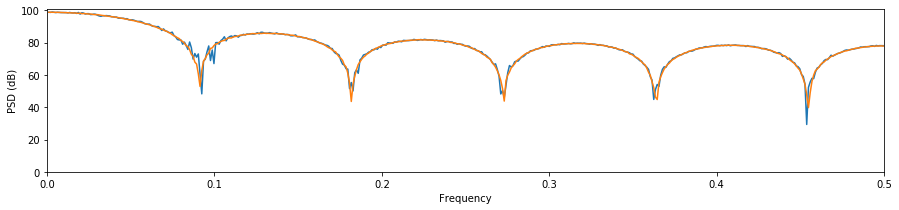

In [227]:
# Interpreting the frequency domains over the full period doesn't do the trick
fig, ax = plt.subplots(1, 1, figsize=(15,3))
ax.plot(fftfreq[i] * frame_rate, 10 * np.log10(temp_psd[i]))
#ax.plot(fftfreq[i] * frame_rate, temp_psd[i])
ax.set_xlim(0, 0.5)
ax.set_ylim(0, 101)
ax.set_xlabel('Frequency')
ax.set_ylabel('PSD (dB)')


In [228]:
# so apply windowing first - chopping the time series into overlapping 6h windows (with ~72 datapoints)
M = 72
df_temp['timestamp'] = df_temp.index
temperature = df_temp[['TEMPERATURE']].to_numpy().reshape(-1,)
pressure = df_temp[['PRESSURE']].to_numpy().reshape(-1,)

#print (temperature.shape, M)
slices = skiutil.view_as_windows(temperature, window_shape=(M,))
slices.shape

hann = np.hanning(M + 1)[:-1]
slices = slices * hann
slices = slices.T
slices.shape

(72, 892)

In [229]:
spectrum = np.fft.fft(slices, axis=0)[:M // 2 + 1:-1]
spectrum = np.abs(spectrum)

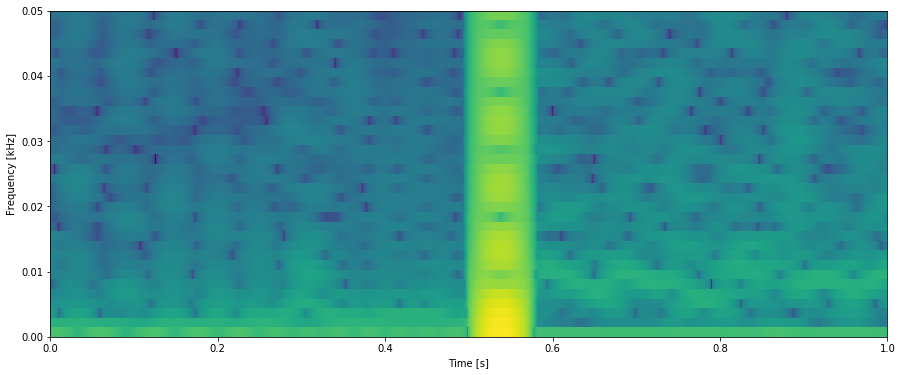

In [230]:
fig, ax = plt.subplots(1, 1, figsize=(15,6))

S = 20 * np.log10(spectrum / np.max(spectrum))

ax.imshow(S, origin='lower', cmap='viridis',
          extent=(0, 1, 0, 100 / 2 / 1000))
ax.axis('tight')
ax.set_ylabel('Frequency [kHz]')
ax.set_xlabel('Time [s]');


2019-10-02T20:16:04.369 WARNING matplotlib.legend._parse_legend_args No handles with labels found to put in legend.
2019-10-02T20:16:04.372 WARNING matplotlib.legend._parse_legend_args No handles with labels found to put in legend.
2019-10-02T20:16:04.377 WARNING matplotlib.legend._parse_legend_args No handles with labels found to put in legend.
2019-10-02T20:16:04.380 WARNING matplotlib.legend._parse_legend_args No handles with labels found to put in legend.


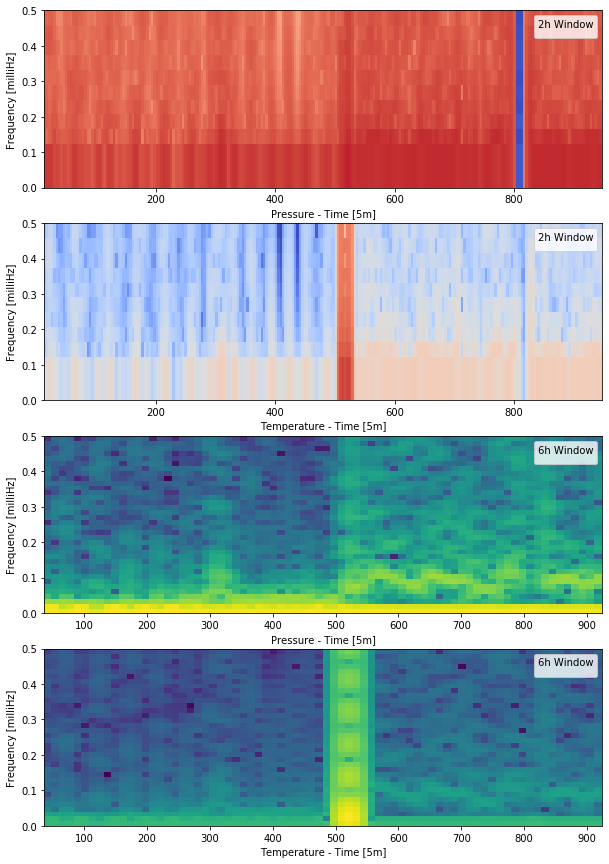

In [257]:
# this is a bit easier
from scipy import signal

rate = 1
MS = 24 # 2hours
ML = 72 # 6hours
freqsPS, timesPS, SxPS = signal.spectrogram(pressure, fs=rate, window='hanning',
                                      nperseg=MS, noverlap=MS - MS/6,
                                      detrend=False, scaling='spectrum')
freqsTS, timesTS, SxTS = signal.spectrogram(temperature, fs=rate, window='hanning',
                                      nperseg=MS, noverlap=MS - MS/6,
                                      detrend=False, scaling='spectrum')
freqsPL, timesPL, SxPL = signal.spectrogram(pressure, fs=rate, window='hanning',
                                      nperseg=ML, noverlap=ML - ML/6,
                                      detrend=False, scaling='spectrum')
freqsTL, timesTL, SxTL = signal.spectrogram(temperature, fs=rate, window='hanning',
                                      nperseg=ML, noverlap=ML - ML/6,
                                      detrend=False, scaling='spectrum')
# cut off frequencies too low to fit into the window the window

freqsPSb = (freqsPS > 2/MS).astype(int)
freqsTSb = (freqsTS > 2/MS).astype(int)
#freqsPSb = (freqsPS in range(0.4, 0.5)).astype(int)

freqsPS = freqsPS * freqsPSb
freqsTS = freqsTS * freqsTSb

#EPS = np.dot(SxPS.T, freqsPS)
#EPS = np.log10(np.dot(SxPS.T, freqsPS))
EPS = np.log10(np.dot(SxPS.T, freqsPS))
ETS = np.log10(np.dot(SxTS.T, freqsTS))

f, ax = plt.subplots(4,1,figsize=(10,15))
ax[0].pcolormesh(timesPS, freqsPS, 10 * np.log10(SxPS), cmap='coolwarm')
ax[0].set_ylabel('Frequency [milliHz]')
ax[0].set_xlabel('Pressure - Time [5m]')
ax[0].legend(title='2h Window')

ax[1].pcolormesh(timesTS, freqsTS, 10 * np.log10(SxTS), cmap='coolwarm')
ax[1].set_ylabel('Frequency [milliHz]')
ax[1].set_xlabel('Temperature - Time [5m]')
ax[1].legend(title='2h Window')

ax[2].pcolormesh(timesPL, freqsPL, 10 * np.log10(SxPL)) #, cmap='viridis')
ax[2].set_ylabel('Frequency [milliHz]')
ax[2].set_xlabel('Pressure - Time [5m]')
ax[2].legend(title='6h Window')

ax[3].pcolormesh(timesTL, freqsTL, 10 * np.log10(SxTL)) #, cmap='viridis')
ax[3].set_ylabel('Frequency [milliHz]')
ax[3].set_xlabel('Temperature - Time [5m]')
ax[3].legend(title='6h Window')




In [261]:
# compute zscore over the energy
eps_zscore = (EPS - EPS.mean())/EPS.std(ddof=0)
ets_zscore = (ETS - ETS.mean())/ETS.std(ddof=0)

# absolute zscore > 3 ---> anomaly
eps_zscoreb = abs((eps_zscore > 3).astype(float) + (eps_zscore < -3).astype(float))
ets_zscoreb = abs((ets_zscore > 3).astype(float) + (ets_zscore < -3).astype(float))

# make matplotlib not plot the zeroes
eps_zscoreb[eps_zscoreb == 0] = 'nan'
ets_zscoreb[ets_zscoreb == 0] = 'nan'


(235,)

Text(0, 0.5, 'Temperature - Energy')

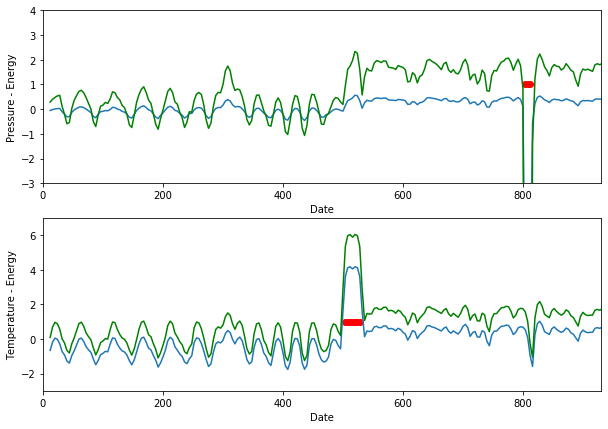

In [258]:
#EPS = np.dot(SxPS.T, freqsPS)
#EPS = np.log10(np.dot(SxPS.T, freqsPS))
EPS = np.log10(np.dot(SxPS.T, freqsPS))
ETS = np.log10(np.dot(SxTS.T, freqsTS))

f, ax = plt.subplots(2,1,figsize=(10,7))
ax[0].plot(timesPS, eps_zscore)
ax[0].plot(timesPS, EPS, color = 'green')
ax[0].set_ylim(-3, 4)
ax[0].set_xlim(0, 930)
ax[0].scatter(timesPS, eps_zscoreb, color = 'red')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Pressure - Energy')
ax[1].plot(timesPS, ets_zscore)
ax[1].plot(timesTS, ETS, color = 'green')
ax[1].set_ylim(-3, 7)
ax[1].set_xlim(0, 930)
ax[1].scatter(timesTS, ets_zscoreb, color = 'red')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Temperature - Energy')

Text(0, 0.5, 'Derivative Temperature')

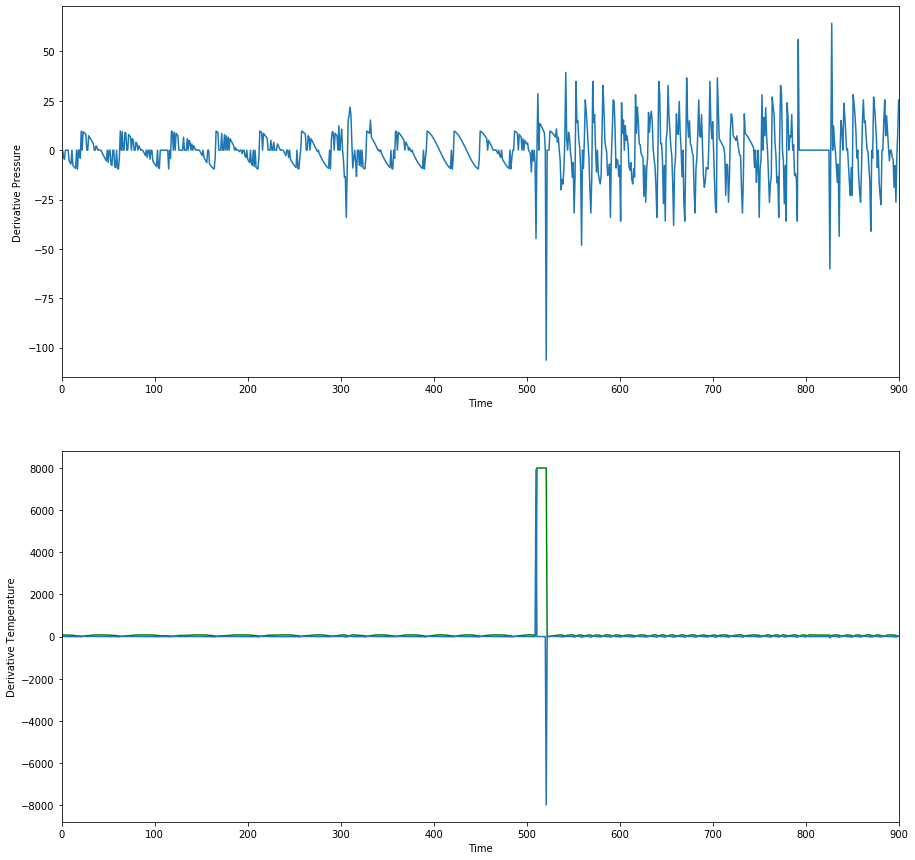

In [289]:
# look at the first discrete derivate (time)
temp_dvp = np.append(np.diff(df_temp['PRESSURE']),0)
temp_dvt = np.append(np.diff(df_temp['TEMPERATURE']),0)
temp_t = df_temp['TEMPERATURE'].values

temp_dt = (df_temp.index.values.astype(np.int64) -1569521100000000000) / 300000000000
fig, ax = plt.subplots(2, 1, figsize=(15,15))
ax[0].plot(temp_dt, temp_dvp)
ax[0].set_xlim(0, 900)
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Derivative Pressure')
ax[1].plot(temp_dt, temp_t, color='green')
ax[1].plot(temp_dt, temp_dvt)
ax[1].set_xlim(0, 900)
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Derivative Temperature')

In [274]:
from pyod.models.knn import KNN
from pyod.models.cblof import CBLOF
#knn = KNN()
cblof = CBLOF(n_clusters=10, n_jobs=-1)
#pred = knn.fit_predict(temp_dvt.reshape(-1,1))
cblof.fit(temp_t.reshape(-1,1))
pred = cblof.predict(temp_t.reshape(-1,1))

In [275]:
#l_dvt = temp_dvt * pred
l_dvt = temp_t * pred
l_dvt[l_dvt == 0] = 'nan'

Text(0, 0.5, 'D Temperature')

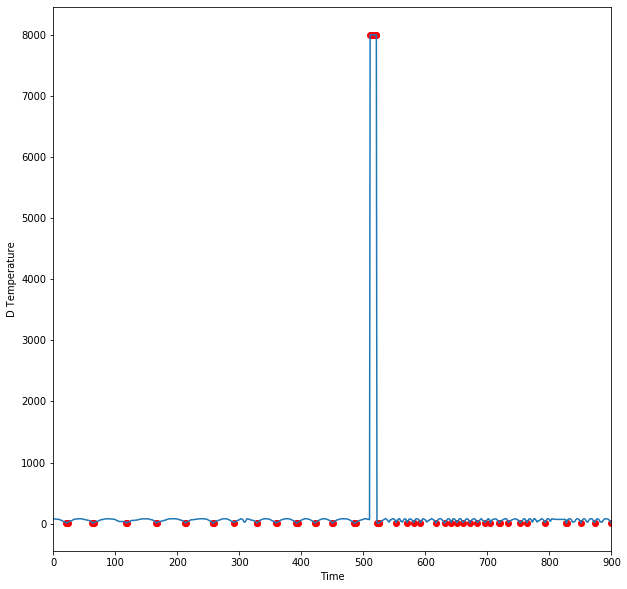

In [290]:
# neither KNN nor CBLOF (K-means) are really suitable it seems, but zscore would definitively do
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.plot(temp_dt, temp_t)
ax.scatter(temp_dt, l_dvt, color = 'red')

ax.set_xlim(0, 900)
ax.set_xlabel('Time')
ax.set_ylabel('D Temperature')

#df_temp.plot(ax=ax[1], lw=.5, y='TEMPERATURE')
#ax[1].set_ylim(15, 120)
#ax[1].set_xlabel('Date')
#ax[1].set_ylabel('Temperature')